## Problem Understanding

The objective of this analysis is to understand customer travel behaviour and booking patterns
using ticket-level data provided by Freshbus.

The analysis focuses on:
1. Understanding how different customer segments travel across routes, time of travel, and bus type.
2. Understanding how far in advance customers book their journeys.

The insights derived can help improve service scheduling, bus configuration, and customer experience.


In [1]:
# Importing required libraries for data analysis
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#shows all rows of the data
pd.set_option("display.max_rows" , None)

In [3]:
#loads sample csv file into the python
df1 = pd.read_csv('ticket.csv')

A copy of the original dataset is created to ensure the raw data remains unchanged
during analysis.

In [4]:
df = df1.copy()

Random samples from the dataset are viewed to understand the structure and nature
of the data without bias from top rows.

In [5]:
df.sample()

,Ticket No,Service Number,Journey Date,Seat Fare,Total Ticket Amount,Category,Age,Gender,Booked Date Time,Journey Date Time
165,ABC166,TP-BN-AC-SE-2030,2026-01-09,349,349.0,PayTM,29,M,2026-01-09 17:50:39,2026-01-09 20:30:00


# **Deriving Relevant Fields From The Service Number**

## Deriving Route from Service Number

The service number contains encoded information about the journey. The first two components represent the source and destination of the route.

Example:
CHN-BNG-AC-SE-1930 → CHN-BNG

A custom function is used to extract and store the route information as a separate column for further analysis.


In [6]:
route_encode = df['Service Number'].str.split('-').str[:2]

In [7]:
# Function to extract route from service number
def route_encode(text):
    route_encode_new = text.split('-')[:2]
    return "-".join(route_encode_new)

In [8]:
# Applying function to extract route
route_encode =  df['Service Number'].apply(route_encode)    

In [9]:
df.insert(1,'Encode Route' , route_encode)

In [10]:
text = 'CHN-BNG-AC-SE-1930'

In [11]:
text.find('SL')

-1

In [12]:
df['Service Number']

0            BN-TP-AC-SE-0700
1            TP-BN-AC-SE-0700
2            TP-BN-AC-SE-0700
3       CHN-BNG-AC-SE/SL-1930
4            TP-BN-AC-SE-1115
5            TP-BN-AC-SE-1115
6            TP-BN-AC-SE-1115
7            BN-TP-AC-SE-1230
8            BN-TP-AC-SE-1230
9            BN-TP-AC-SE-1230
10           TP-BN-AC-SE-0800
11           TP-BN-AC-SE-0800
12           TP-BN-AC-SE-0800
13           TP-BN-AC-SE-0800
14        VSKP-GNT-AC-SE-2030
15        VSKP-GNT-AC-SE-2030
16         ERD-BNG-AC-SE-2100
17         HYD-ELR-AC-SE-1930
18      GNT-HYD-AC-SE/SL-2200
19        VSKP-GNT-AC-SE-2030
20        VSKP-GNT-AC-SE-2030
21      VJY-HYD-AC-SE/SL-1000
22         HYD-ELR-AC-SE-2030
23     GNT-VSKP-AC-SE/SL-2030
24     GNT-VSKP-AC-SE/SL-2200
25     GNT-VSKP-AC-SE/SL-2030
26           BN-TP-AC-SE-2300
27           BN-TP-AC-SE-2300
28     GNT-VSKP-AC-SE/SL-2030
29      VJY-HYD-AC-SE/SL-1000
30         ELR-HYD-AC-SE-2100
31         ELR-HYD-AC-SE-2100
32         PND-CHN-AC-SE-0900
33        

## Identifying Bus Type (Sleeper vs Seater)

The service number contains information about the bus configuration. If the service number includes 'SL', the bus is considered a sleeper bus. A binary indicator is created to represent sleeper (1) and seater (0) buses.


In [13]:
# Function to check whether a bus is a sleeper bus
def is_Sleeper_bus(text):
    text = text.find('SL')     # Check if 'SL' exists in the service number
    if text == -1:             # If 'SL' is not found, return 0 (Seater)
        return 0 
    return 1                   # If 'SL' is found, return 1 (Sleeper)


In [14]:
df['Service Number'].str.contains('SL').value_counts()

Service Number
False    335
True     164
Name: count, dtype: int64

In [15]:
# Applying the sleeper check function to the Service Number column
is_Sleeper = df['Service Number'].apply(is_Sleeper_bus)

In [16]:
# Inserting the isSleeper column into the dataframe
df.insert(2 , 'isSleeper' , is_Sleeper)

In [17]:
# Viewing a random sample to verify results
df.sample(2)

,Ticket No,Encode Route,isSleeper,Service Number,Journey Date,Seat Fare,Total Ticket Amount,Category,Age,Gender,Booked Date Time,Journey Date Time
3,ABC04,CHN-BNG,1,CHN-BNG-AC-SE/SL-1930,2025-12-24,1765,1765.0,Online,28,M,2025-11-26 12:44:45,2025-12-24 20:45:00
335,ABC336,GNT-VSKP,0,GNT-VSKP-AC-SE-1930,2026-01-09,1409,1409.0,Redbus,18,F,2026-01-09 18:25:17,2026-01-09 21:00:00


## Extracting Departure Time from Service Number

The last part of the service number represents the departure time in HHMM format. This is converted into a readable HH:MM format for time-based analysis.


In [18]:
# Function to extract departure time from service number
def departure_time_func(text):
    time_part = text.split('-')[-1]         # Extract the last part of the service number (HHMM)
    hour = time_part[:2]                    # Separate hour and minute
    minute = time_part[2:]
    return f"{hour}:{minute}"               # Return time in HH:MM format

In [19]:
def departure_time_func(text):
    hour = []
    min = []
    hour.append(text.split('-')[-1][0:2])
    min.append(text.split('-')[-1][2:4])
    hour = "".join(hour)
    min = "".join(min)
    return f"{hour}:{min}"

In [20]:
# Applying the function to extract departure time
departure_time = df['Service Number'].apply(departure_time_func)

In [21]:
# Inserting Departure Time column into the dataframe
df.insert(3 , 'Departure Time' , departure_time)

## Categorising Time of Travel

Departure times are grouped into meaningful time buckets to understand customer travel preferences across different parts of the day.

In [22]:
# Function to classify departure time into time-of-day buckets
def time_of_day_bucket(text):
    if ((text > "05:00") & (text <= "09:00")):
        return "Early Morning"
    elif ((text > "09:00") & (text <= "16:00")):
        return "Day Service"
    elif((text > "16:00") & (text <= "21:00")):
        return "Evening"
    else:
        return "Overnight"

In [23]:
# Applying time bucket classification
day = df['Departure Time'].apply(time_of_day_bucket)

In [24]:
# Inserting Time Of Travel column
df.insert(10 , 'Time Of Travel' , day)

In [25]:
# Viewing sample rows
df.sample(3)

,Ticket No,Encode Route,isSleeper,Departure Time,Service Number,Journey Date,Seat Fare,Total Ticket Amount,Category,Age,Time Of Travel,Gender,Booked Date Time,Journey Date Time
368,ABC369,VJY-HYD,0,10:30,VJY-HYD-AC-SE-1030,2026-01-11,349,349.0,Redbus,31,Day Service,F,2026-01-09 18:30:47,2026-01-11 10:20:00
199,ABC200,CHN-BNG,0,15:30,CHN-BNG-AC-SE-1530,2026-01-09,377,377.0,Redbus,35,Day Service,M,2026-01-09 17:59:46,2026-01-09 20:50:00
278,ABC279,VSKP-GNT,0,20:30,VSKP-GNT-AC-SE-2030,2026-01-09,557,1093.0,PayTM,24,Evening,M,2026-01-09 18:14:30,2026-01-09 20:42:00


## Creating Departure Date Time

Journey date and departure time are combined to create a complete departure datetime for accurate time-based calculations.

In [26]:
# Combining Journey Date and Departure Time
departure_date_time = df['Journey Date'] +' '+  df['Departure Time'] 

In [27]:
# Inserting Departure Date Time column
df.insert(11 , 'Departure Date Time' , departure_date_time)

## Converting Columns to Datetime Format

Date and time columns are converted into datetime format to enable calculations such as booking gap analysis.

In [28]:
# List of columns to convert into datetime format
datetime_cols = ["Booked Date Time", "Departure Date Time", "Journey Date Time"]
# Converting each column to datetime
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col] , format = 'mixed')

In [29]:
# Checking the dataframe after conversion
df.sample()

,Ticket No,Encode Route,isSleeper,Departure Time,Service Number,Journey Date,Seat Fare,Total Ticket Amount,Category,Age,Time Of Travel,Departure Date Time,Gender,Booked Date Time,Journey Date Time
249,ABC250,GNT-HYD,0,17:00,GNT-HYD-AC-SE-1700,2026-01-09,431,1768.0,Online,11,Evening,2026-01-09 17:00:00,F,2026-01-09 18:09:50,2026-01-09 18:40:00


## Creating Departure Date Time

Journey date and departure time are combined to create a complete departure datetime for accurate time-based calculations.

In [30]:
departure_time = df['Departure Date Time'].dt.time

## Data Cleanup

Redundant columns are removed after creating the required datetime fields.

In [31]:
# Dropping unnecessary columns
df.drop(columns=['Departure Time' , 'Journey Date'] , inplace=True)

In [32]:
# Checking cleaned dataframe
df.sample(3)

,Ticket No,Encode Route,isSleeper,Service Number,Seat Fare,Total Ticket Amount,Category,Age,Time Of Travel,Departure Date Time,Gender,Booked Date Time,Journey Date Time
93,ABC94,VSKP-GNT,1,VSKP-GNT-AC-SE/SL-2300,1009,1009.0,PayTM,19,Overnight,2026-01-09 23:00:00,M,2026-01-09 17:34:51,2026-01-09 23:05:00
389,ABC390,BN-TP,0,BN-TP-AC-SE-0530,831,1588.0,Redbus,22,Early Morning,2026-01-10 05:30:00,F,2026-01-09 18:35:52,2026-01-10 06:35:00
311,ABC312,GNT-VSKP,1,GNT-VSKP-AC-SE/SL-2030,2431,2431.0,Redbus,37,Evening,2026-01-09 20:30:00,M,2026-01-09 18:21:30,2026-01-09 22:35:00


## Booking Gap Calculation

Booking gap represents the number of days between ticket booking and the actual journey date.

In [33]:
# Calculating booking gap in days
df["Booking Gap Days"] = (df["Journey Date Time"] - df["Booked Date Time"]).dt.days

## Creating Age Groups

Customers are segmented into age groups to analyse travel and booking behaviour across different age demographics.

In [34]:
# Creating age group categories
df["Age Group"] = pd.cut(
    df["Age"],
    bins=[1, 17 , 25, 40, 60, 100],
    labels=["1-17" , "18-25", "26-40", "41-60", "60+"]
)

### **Checking DataType**

## Checking Data Types and Dataset Structure

Before performing analysis, it is important to understand the structure of the dataset, including column names, data types, and presence of missing values.

In [35]:
# Displaying information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Ticket No            499 non-null    object        
 1   Encode Route         499 non-null    object        
 2   isSleeper            499 non-null    int64         
 3   Service Number       499 non-null    object        
 4   Seat Fare            499 non-null    int64         
 5   Total Ticket Amount  499 non-null    float64       
 6   Category             499 non-null    object        
 7   Age                  499 non-null    int64         
 8   Time Of Travel       499 non-null    object        
 9   Departure Date Time  499 non-null    datetime64[ns]
 10  Gender               499 non-null    object        
 11  Booked Date Time     499 non-null    datetime64[ns]
 12  Journey Date Time    499 non-null    datetime64[ns]
 13  Booking Gap Days     499 non-null  

# **EDA**

## Exploratory Data Analysis (EDA)

Basic exploratory analysis is performed to understand overall patterns and distributions in the dataset before deeper segmentation.

## Basic EDA

### Bus Type Preference (Seater vs Sleeper)

This analysis helps understand whether customers prefer seater buses or sleeper buses based on booking counts.

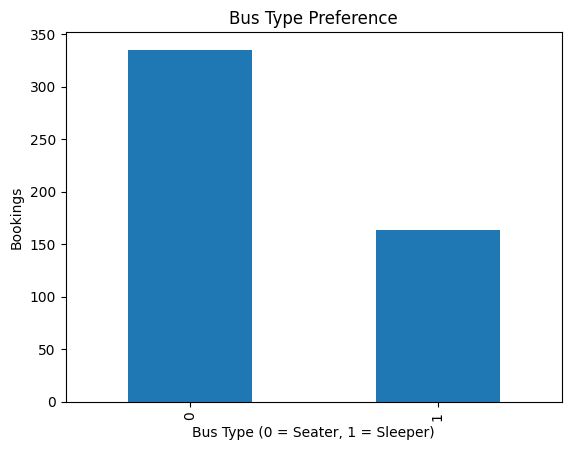

In [36]:
# Counting number of bookings for each bus type
# 0 represents Seater buses, 1 represents Sleeper buses
bus_type_counts = df["isSleeper"].value_counts() 

# Creating a bar chart to visualise bus type preference
plt.figure()
bus_type_counts.plot(kind="bar")
plt.title("Bus Type Preference")
plt.xlabel("Bus Type (0 = Seater, 1 = Sleeper)")
plt.ylabel("Bookings")
plt.show()

### Seat Fare Distribution and Outlier Analysis

A box plot is used to understand the distribution of seat fares and to identify the presence of outliers in pricing.

<Axes: >

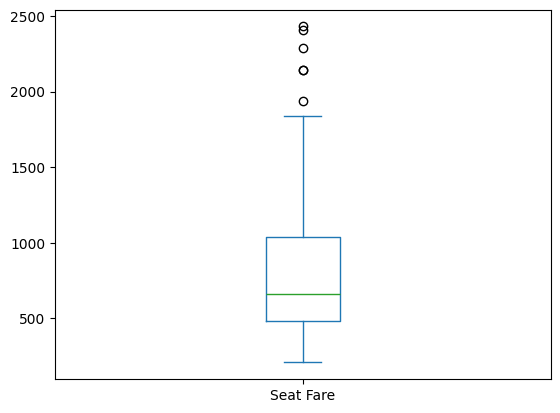

In [37]:
# Visualising the distribution of seat fares using a box plot
df['Seat Fare'].plot(kind='box')

### 📈 Seat Fare Distribution
This histogram visualizes how ticket prices are distributed across all bookings. The KDE curve highlights the overall pricing trend and helps identify skewness or concentration in specific fare ranges.

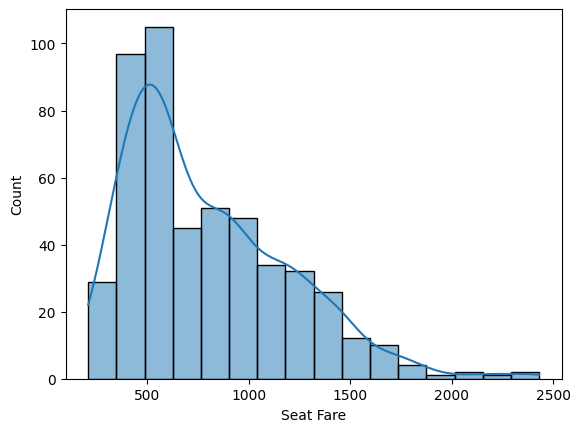

In [38]:
# Plot histogram of Seat Fare to understand fare distribution
# KDE curve is added to observe the overall pricing trend
sns.histplot(df['Seat Fare'] , kde =True)
plt.show() # Explicitly display the plot to avoid printing Axes object

### Bookings by Age Group

This bar chart shows how bookings are distributed across different age groups.It helps identify which customer age segments travel most frequently and can guide targeted marketing and service design decisions.

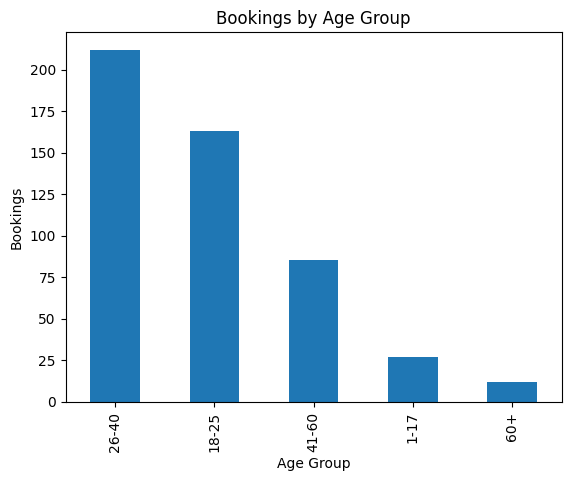

In [39]:
Age_Group_counts = df["Age Group"].value_counts() # Count number of bookings in each age group

plt.figure()  # Create a bar chart to visualize bookings by age group
Age_Group_counts.plot(kind="bar") 
plt.title("Bookings by Age Group") # Add title and axis labels for clarity
plt.xlabel("Age Group")
plt.ylabel("Bookings")
plt.show() # Display the plot

### Bookings by Gender

This bar chart represents the distribution of bookings across genders.It helps understand whether there is any gender-based difference in travel
participation and demand patterns.

<Axes: xlabel='Gender (1 = Male , 0 = Female)', ylabel='Count'>

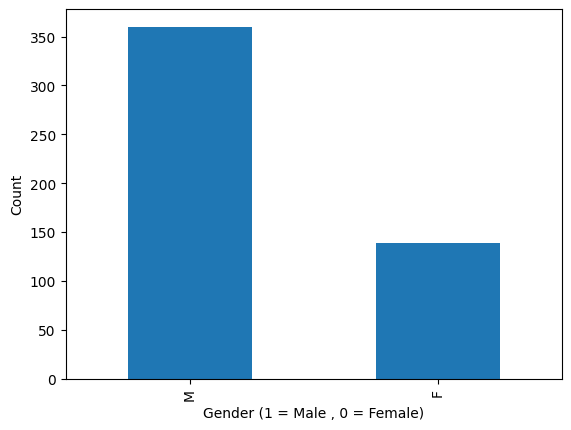

In [40]:
# Count number of bookings by gender
# Plot bar chart to visualize gender-wise booking distribution
# Display the plot
df['Gender'].value_counts().plot(kind='bar' , xlabel="Gender (1 = Male , 0 = Female)" , ylabel="Count")

### Data Quality Check - Zero Ticket Amounts
This step identifies records where the total ticket amount is zero.Such entries may indicate free tickets, cancellations, system errors,
or incomplete transactions and should be reviewed before analysis.

In [41]:
# Filter records where Total Ticket Amount is zero
df[df['Total Ticket Amount'] == 0]

,Ticket No,Encode Route,isSleeper,Service Number,Seat Fare,Total Ticket Amount,Category,Age,Time Of Travel,Departure Date Time,Gender,Booked Date Time,Journey Date Time,Booking Gap Days,Age Group
17,ABC18,HYD-ELR,0,HYD-ELR-AC-SE-1930,1499,0.0,Redbus,22,Evening,2026-01-10 19:30:00,M,2026-01-10 17:11:37,2026-01-10 21:20:00,0,18-25
19,ABC20,VSKP-GNT,0,VSKP-GNT-AC-SE-2030,494,0.0,Abhibus,20,Evening,2026-01-13 20:30:00,M,2026-01-13 13:19:06,2026-01-13 20:30:00,0,18-25
20,ABC21,VSKP-GNT,0,VSKP-GNT-AC-SE-2030,494,0.0,Abhibus,53,Evening,2026-01-13 20:30:00,M,2026-01-13 13:19:06,2026-01-13 20:30:00,0,41-60
23,ABC24,GNT-VSKP,1,GNT-VSKP-AC-SE/SL-2030,567,0.0,Online,19,Evening,2026-01-13 20:30:00,M,2026-01-13 12:52:16,2026-01-13 21:35:00,0,18-25
24,ABC25,GNT-VSKP,1,GNT-VSKP-AC-SE/SL-2200,620,0.0,Online,33,Overnight,2026-01-13 22:00:00,M,2026-01-13 13:00:13,2026-01-13 22:00:00,0,26-40
25,ABC26,GNT-VSKP,1,GNT-VSKP-AC-SE/SL-2030,599,0.0,PayTM,30,Evening,2026-01-13 20:30:00,M,2026-01-13 12:41:18,2026-01-13 22:00:00,0,26-40
28,ABC29,GNT-VSKP,1,GNT-VSKP-AC-SE/SL-2030,578,0.0,Abhibus,31,Evening,2026-01-13 20:30:00,M,2026-01-13 13:06:14,2026-01-13 22:15:00,0,26-40
29,ABC30,VJY-HYD,1,VJY-HYD-AC-SE/SL-1000,359,0.0,Redbus,15,Day Service,2026-01-10 10:00:00,M,2026-01-10 07:34:13,2026-01-10 11:30:00,0,1-17
30,ABC31,ELR-HYD,0,ELR-HYD-AC-SE-2100,637,0.0,Redbus,51,Evening,2026-01-12 21:00:00,F,2026-01-10 00:00:26,2026-01-12 21:10:00,2,41-60
31,ABC32,ELR-HYD,0,ELR-HYD-AC-SE-2100,658,0.0,Redbus,56,Evening,2026-01-12 21:00:00,M,2026-01-10 00:00:26,2026-01-12 21:10:00,2,41-60


## II. Identifying Patterns Across Root

## II. Identifying Patterns Across Routes

This analysis identifies the most frequently booked routes.Understanding high-demand routes helps in optimizing bus frequency,
capacity planning, and route-level service improvements.

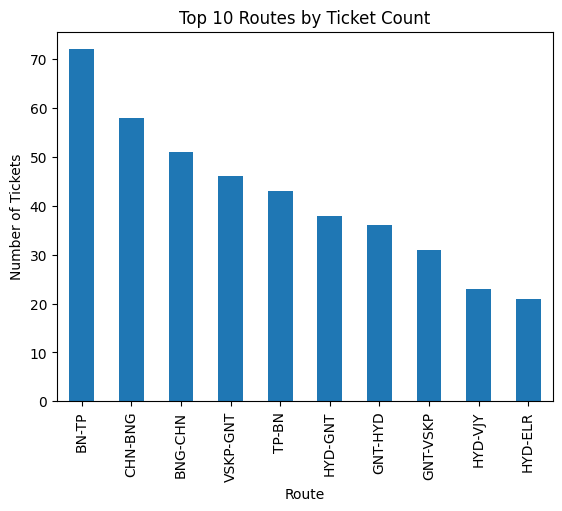

In [42]:
route_counts = df["Encode Route"].value_counts().head(10) # Count number of tickets booked for each route
plt.figure()                                              # Create a bar chart for the top 10 most booked routes
route_counts.plot(kind="bar")
plt.title("Top 10 Routes by Ticket Count")                # Add title and axis labels for clarity
plt.xlabel("Route")
plt.ylabel("Number of Tickets")
plt.show()                                                # Display the plot

### Extracting Unique Routes

This step extracts all unique routes present in the dataset. It helps understand route coverage and is useful for route-level
analysis, looping, or comparative studies across different routes.

In [43]:
# Extract all unique route values from the Encode Route column
# Convert them into a Python list for easy iteration or analysis
routes = df['Encode Route'].unique().tolist()
# Display the list of unique routes
routes

['BN-TP',
 'TP-BN',
 'CHN-BNG',
 'VSKP-GNT',
 'ERD-BNG',
 'HYD-ELR',
 'GNT-HYD',
 'VJY-HYD',
 'GNT-VSKP',
 'ELR-HYD',
 'PND-CHN',
 'HYD-VJY',
 'HYD-GNT',
 'BNG-CHN',
 'CHN-PND',
 'VJY-VSKP',
 'VSKP-VJY',
 'BNG-ERD']

### Total Ticket Amount Vs Category As per route

### Total Ticket Amount vs Category (Route-wise Analysis)

This analysis examines how total revenue varies across different ticket
categories for each route.

By visualizing revenue contribution category-wise for every route,
we can:
- Identify high-revenue categories per route
- Understand customer preference differences across routes
- Support pricing, category optimization, and route-level strategy


In [44]:
# Create a pivot table to calculate total ticket revenue
# grouped by Route and Category
revenue = pd.pivot_table(df,
                        values='Total Ticket Amount',
                        index=['Encode Route' , 'Category'],
                        aggfunc='sum'
                    )

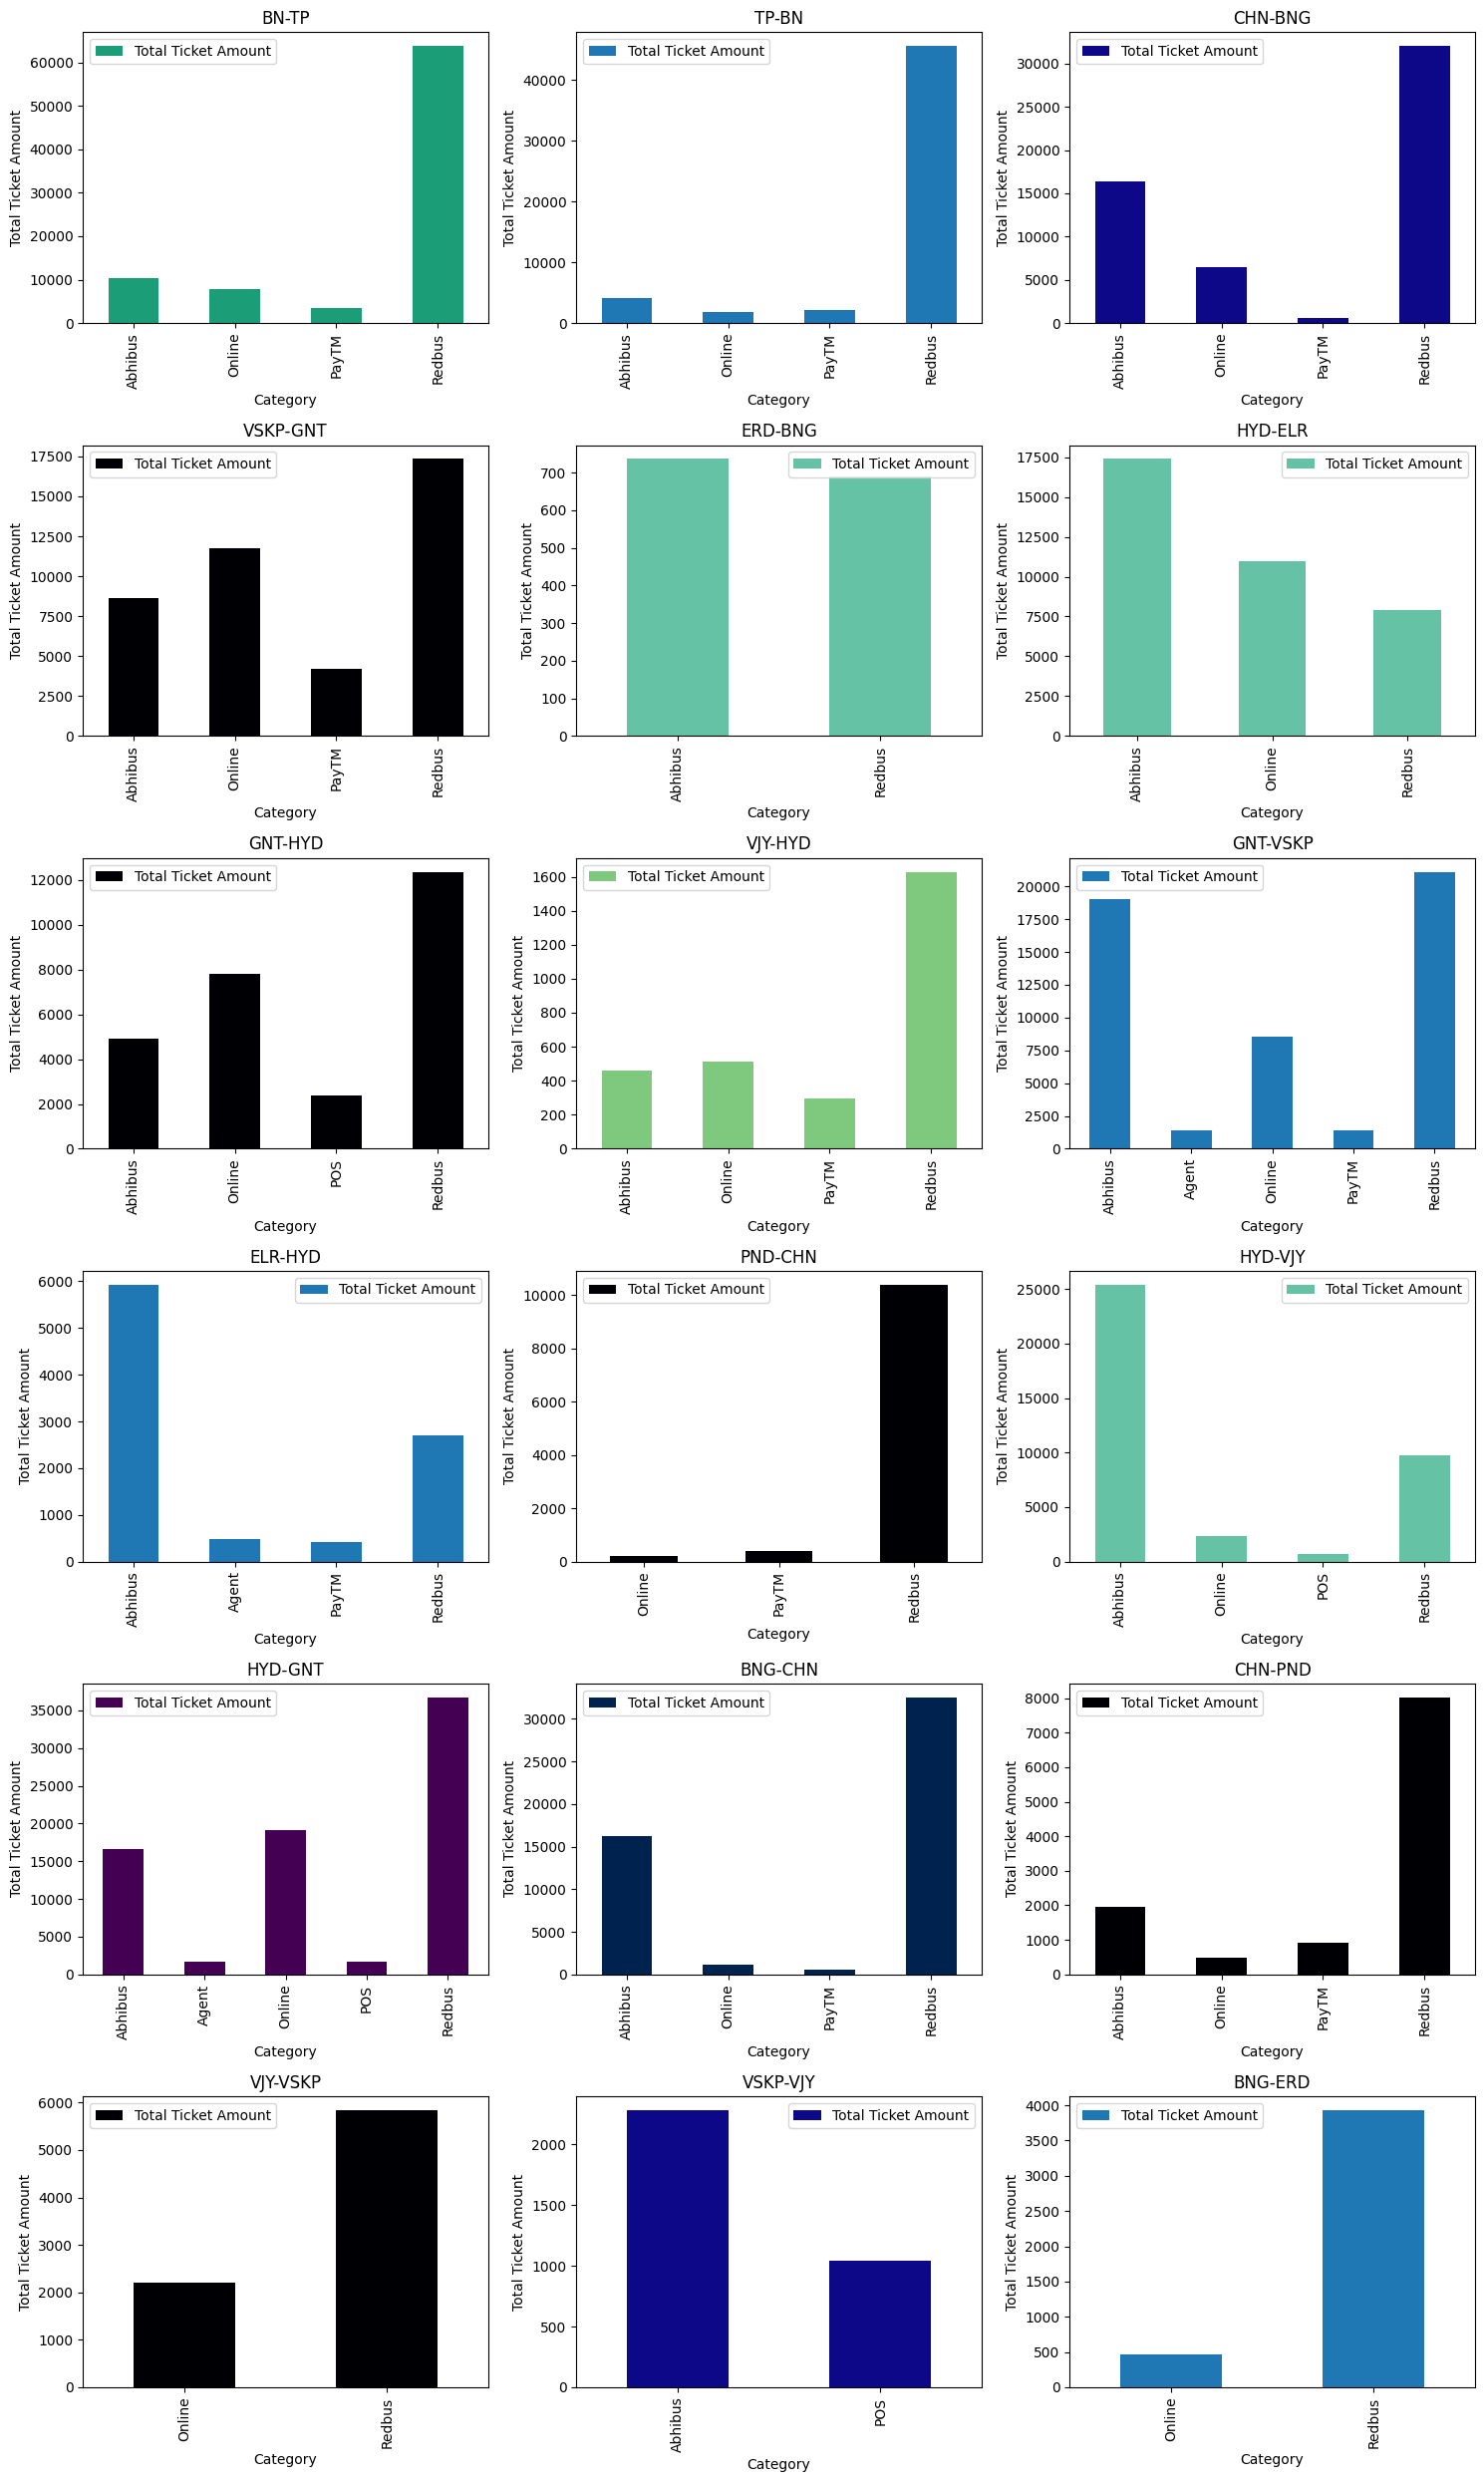

In [45]:
import random                                    # Import required libraries for plotting
fig, ax = plt.subplots(6, 3, figsize=(15, 25))   # Create a grid of subplots (6 rows x 3 columns).This allows one plot per route
ax = ax.flatten()                                # Convert 2D axes array into 1D for easy indexing
cmaps = [                                         # List of colormaps to randomly style each route plot

    "viridis", "plasma", "inferno", "magma", "cividis",
    "tab10", "tab20", "Set2", "Accent", "Dark2"
]

for i, route in enumerate(routes):               # Loop through each route and generate a bar chart
    revenue.loc[route].plot(                     # Plot category-wise revenue for the given route
        kind='bar',
        ax=ax[i],
        colormap=random.choice(cmaps),
        title=route
    )
    ax[i].set_xlabel("Category")                 # Set axis labels

    ax[i].set_ylabel("Total Ticket Amount")


plt.tight_layout()                               # Adjust spacing between subplots to avoid overlap
plt.show()                                       # Display all plots

### Revenue by Time of Travel (Route-wise Analysis)

This analysis examines how total ticket revenue is distributed across
different times of travel (Early Morning, Day Service, Evening, Overnight)
for each route.

It helps understand:
- Peak revenue-generating travel periods
- Route-specific time preferences
- Opportunities for schedule optimization and capacity planning


In [46]:
categories = df['Category'].unique().tolist()

In [47]:
# Create a pivot table to calculate total revenue
# grouped by Route and Time Of Travel
revenue_by_route_day = pd.pivot_table(df,
                        values='Total Ticket Amount',
                        index=['Encode Route' , 'Time Of Travel'],
                        aggfunc='sum'
                    )

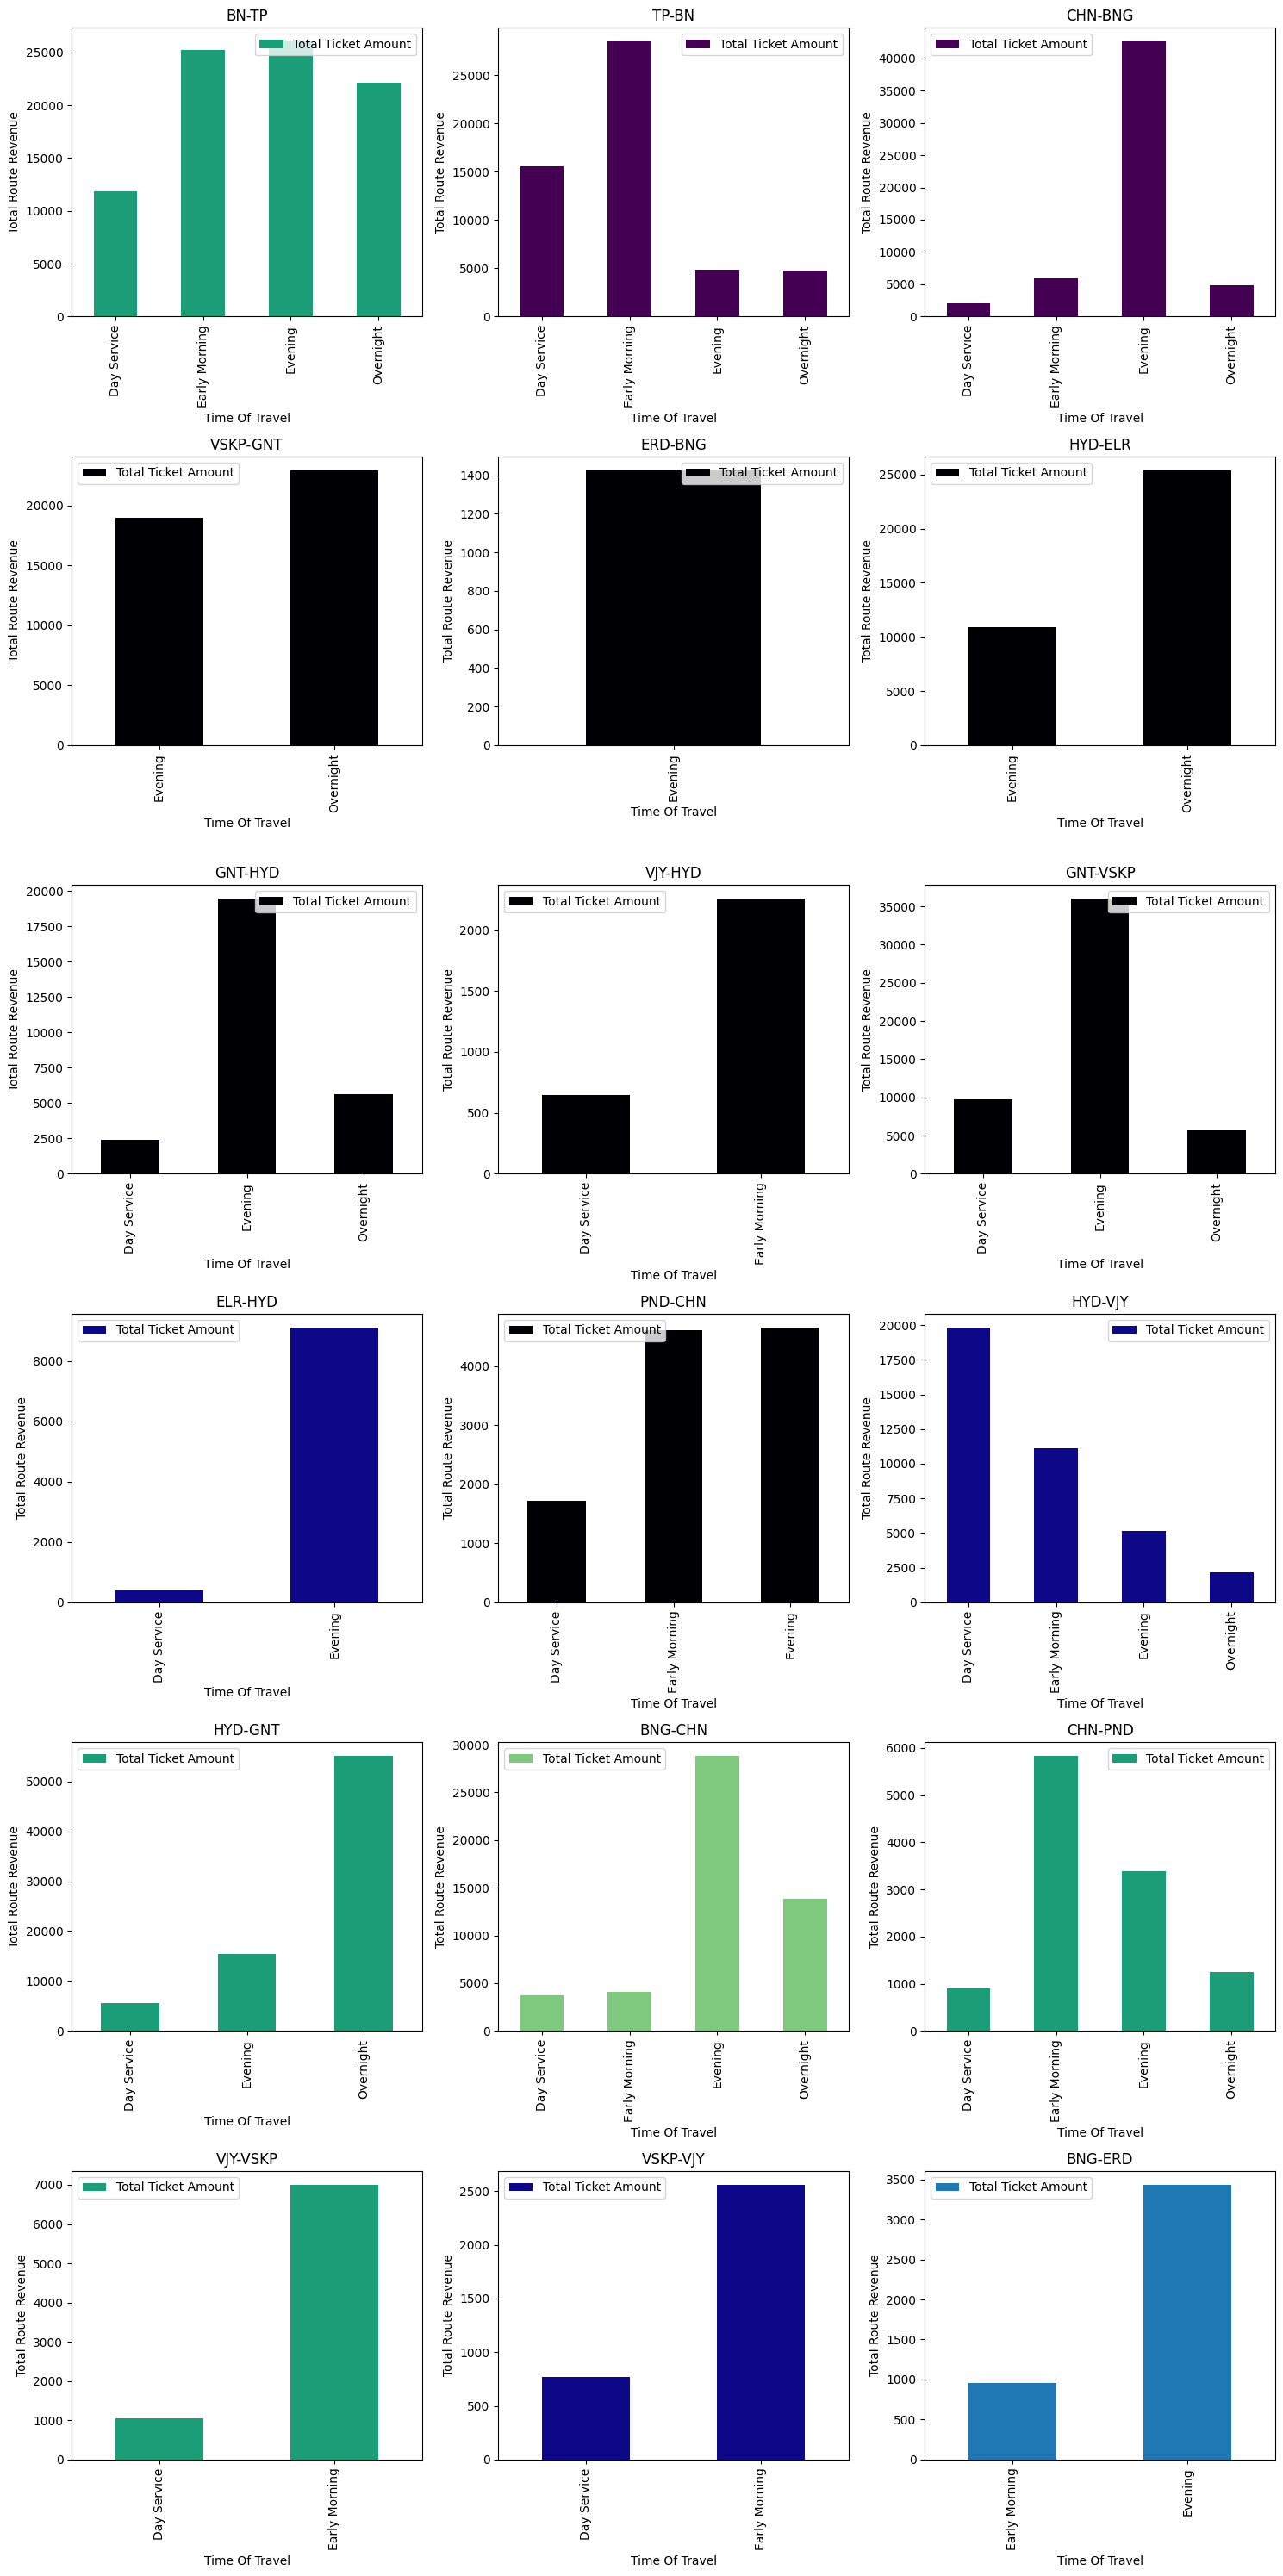

In [48]:
import random                                           # Import random for assigning different color maps
fig, ax = plt.subplots(6, 3, figsize=(15, 30))          # Create subplots grid (6 rows x 3 columns) for route-wise visualization
ax = ax.flatten()                                       # Flatten axes array for easy indexing
cmaps = [                                               # List of color maps to randomly assign to each plot
    "viridis", "plasma", "inferno", "magma", "cividis",
    "tab10", "tab20", "Set2", "Accent", "Dark2"
]

for i, route in enumerate(routes):                      # Loop through each route and plot revenue by time of travel
    revenue_by_route_day.loc[route].plot(               # Plot time-of-travel-wise revenue for the given route
        kind='bar',
        ax=ax[i],
        colormap=random.choice(cmaps),
        title=route
    )
    ax[i].set_xlabel("Time Of Travel")                  # Set axis labels
    ax[i].set_ylabel("Total Route Revenue")


plt.tight_layout()                                      # Adjust spacing to prevent overlapping plots
plt.show()                                              # Display all plots

### Bus Configuration for Different Customer Segments (Age-based Analysis)

This analysis studies how different age groups are distributed across ticket categories. It helps understand whether certain bus configurations or categories are preferred by specific age segments.

In [49]:
# Create a pivot table to count number of bookings
# grouped by Category and Age Group
age_based_analysis = pd.pivot_table(df,
                        values='Age',
                        index=['Category' , 'Age Group'],
                        aggfunc='count',
                        observed=False         # Explicitly defining current behavior
                    )

In [50]:
# Count total number of customers in each age group
# This helps understand overall age distribution in the dataset
df['Age Group'].value_counts()

Age Group
26-40    212
18-25    163
41-60     85
1-17      27
60+       12
Name: count, dtype: int64

In [51]:
categories

['Redbus', 'Online', 'Abhibus', 'PayTM', 'POS', 'Agent']

In [52]:
age_based_analysis.loc['Redbus']

,Age
Age Group,
1-17,11
18-25,77
26-40,116
41-60,52
60+,8


### Age Group Distribution Across Categories

This visualization shows how different age groups are distributed across ticket categories. Each chart represents one category and
highlights the dominant age segments booking that category.
This helps understand customer preferences and supports decisionsrelated to bus configuration, comfort features, and targeted marketing.


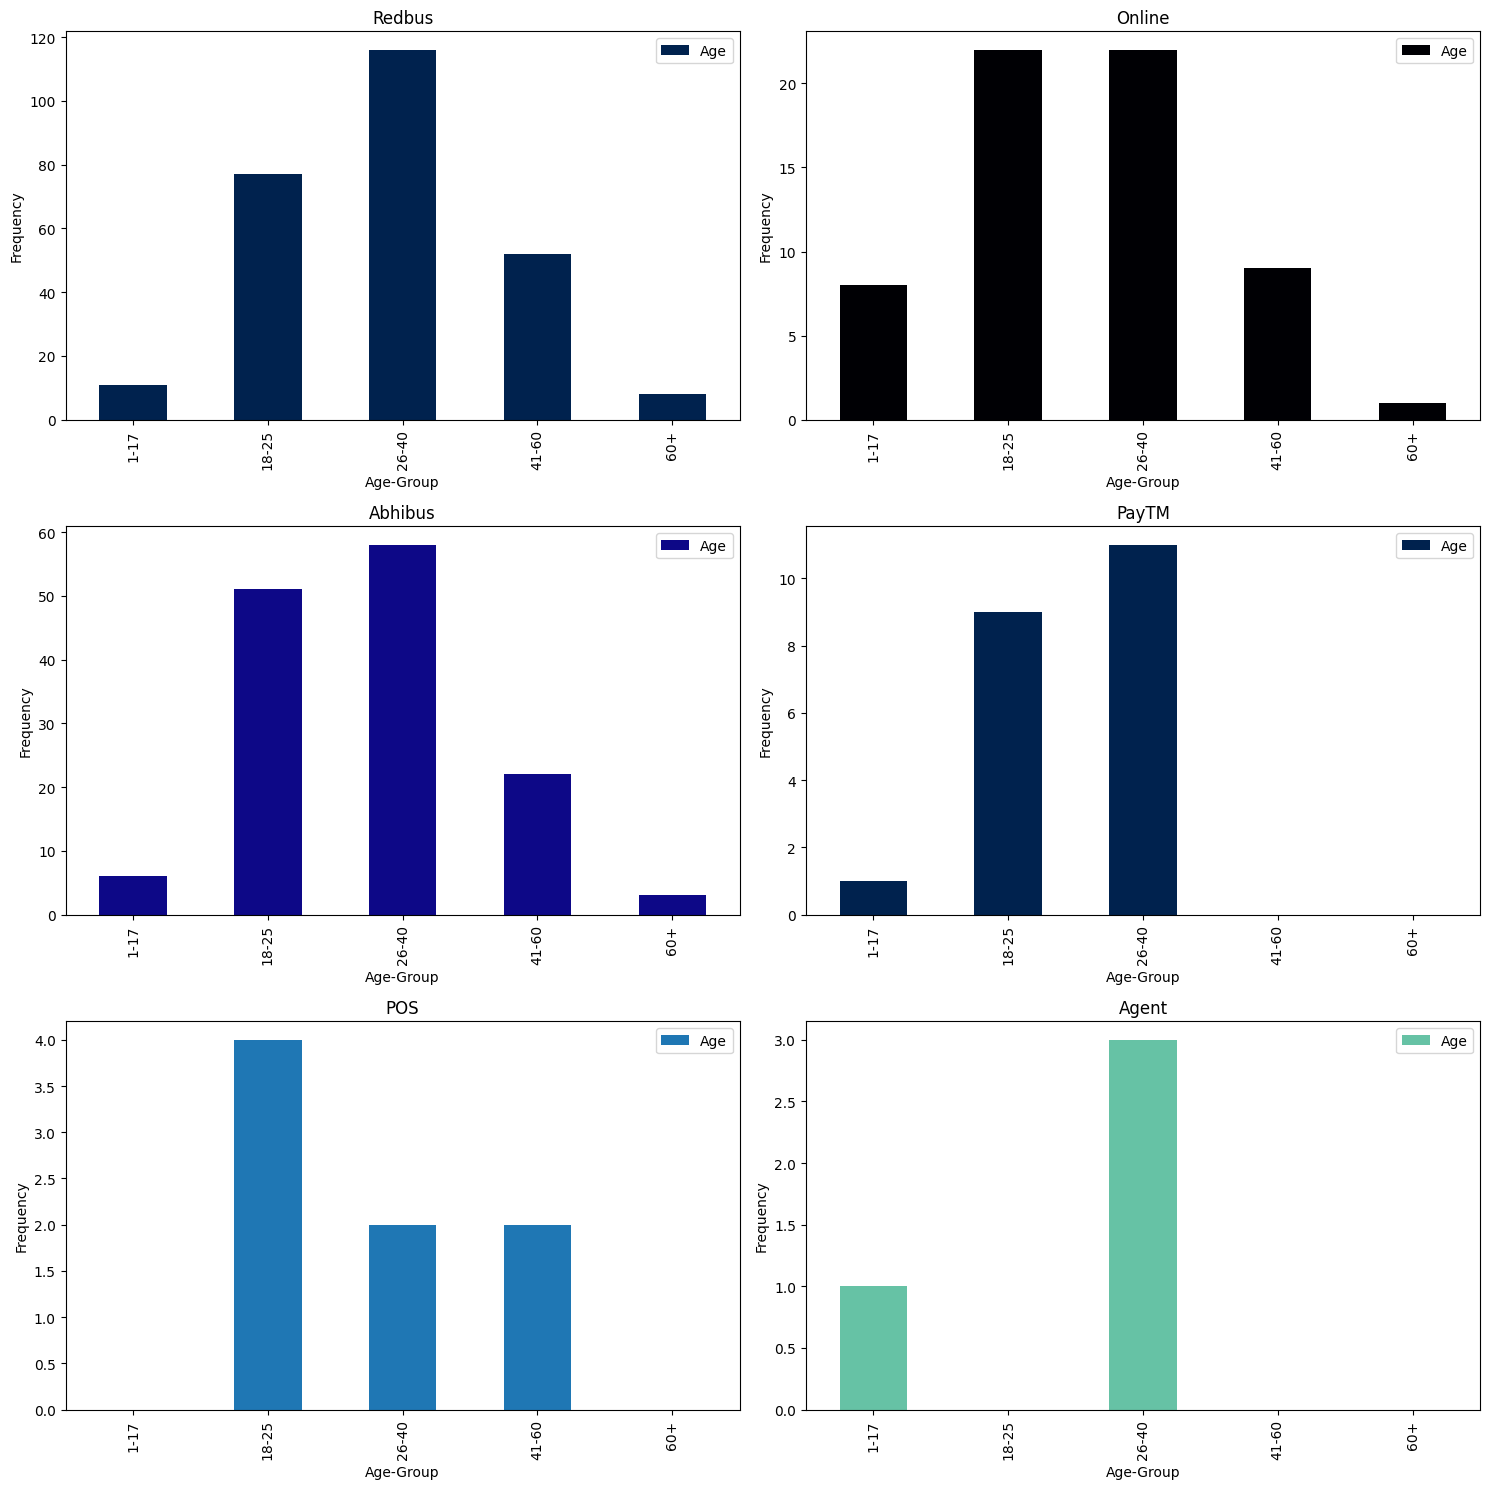

In [53]:
import random                                            # Import random to randomly assign color maps to each plot    
fig, ax = plt.subplots(3, 2, figsize=(15, 15))           # Create a subplot grid (3 rows x 2 columns).Each subplot represents one ticket category
ax = ax.flatten()                                        # Flatten axes for easy indexing
cmaps = [                                                # List of color maps for better visual distinction
    "viridis", "plasma", "inferno", "magma", "cividis",
    "tab10", "tab20", "Set2", "Accent", "Dark2"
]

for i, category in enumerate(categories):                # Loop through each category and plot age-group distribution
    age_based_analysis.loc[category].plot(               # Plot age group frequency for the given category
        kind='bar',
        ax=ax[i],
        colormap=random.choice(cmaps),
        title=category
    )
    ax[i].set_xlabel("Age-Group")                       # Set axis labels
    ax[i].set_ylabel("Frequency")



plt.tight_layout()                                      # Adjust layout to avoid overlap

plt.show()                                              # Display all plots

### Gender-wise Travel Time Preference

This analysis explores how travel time preferences differ across genders. It helps identify whether certain time slots (especially overnight travel) are preferred or avoided by specific gender segments.

Such insights are useful for improving safety features, scheduling,and customer experience design.


In [54]:
# Extract unique gender values for iteration
genders = df['Gender'].unique().tolist()

In [55]:
pd.pivot_table(df,
            values='Ticket No',
            index=['Gender' , 'Time Of Travel'], aggfunc='count'
        )

Ticket No
Gender Time Of Travel           
F      Day Service            21
       Early Morning          33
       Evening                53
       Overnight              32
M      Day Service            41
       Early Morning          42
       Evening               180
       Overnight              97

In [56]:
# Optional check: number of female overnight bookings
# This helps validate safety-related assumptions
df[(df['Gender'] == 'F') & (df['Time Of Travel'] == 'Overnight')].shape

(32, 15)

In [57]:
# Create a pivot table to count bookings
# grouped by Gender and Time Of Travel
gender_time_booking_counts = pd.pivot_table(df,
                        values='Ticket No',
                        index=['Gender' , 'Time Of Travel'],
                        aggfunc='count'
                    )

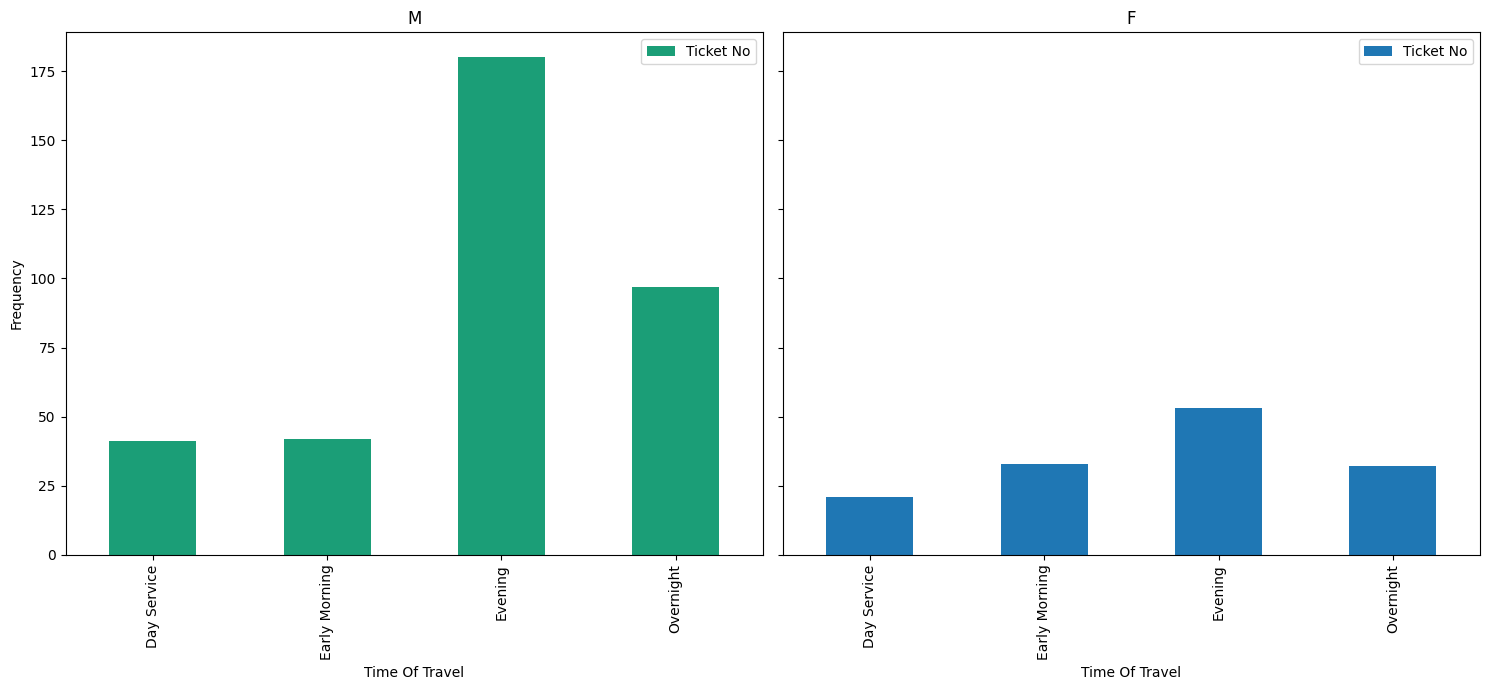

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 7) , sharey=True)     # Create side-by-side plots for male and female passengers

ax = ax.flatten()

cmaps = [                                                       # List of color maps for styling
    "viridis", "plasma", "inferno", "magma", "cividis",
    "tab10", "tab20", "Set2", "Accent", "Dark2"
]

for i, gender in enumerate(genders):                           # Loop through each gender and plot time-of-travel booking frequency
    gender_time_booking_counts.loc[gender].plot(
        kind='bar',
        ax=ax[i],
        colormap=random.choice(cmaps),
        title=gender
    )
    ax[i].set_ylabel("Frequency")                             # Set Y-axis label
plt.tight_layout()                                            # Adjust layout spacing
plt.show()                                                    # Display the plots

## ***Booking Behaviour & Planning Horizon***

This section analyses how far in advance customers book their journeys.
Understanding the booking gap helps in:
- Demand forecasting
- Dynamic pricing strategies
- Improving customer experience through timely communication


Time Gap Between Booking And Journey

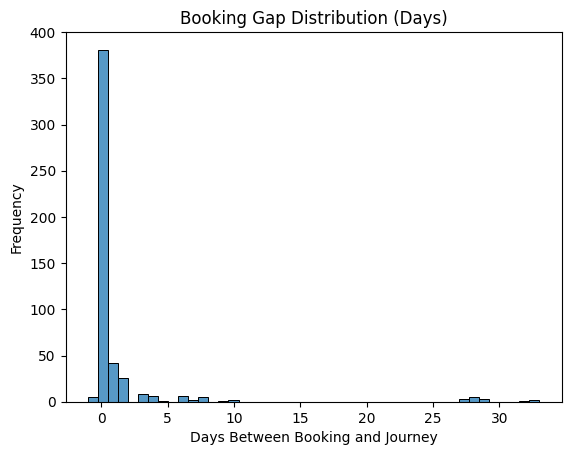

In [59]:
plt.figure()                                      # Plot the distribution of booking gap in days.This shows how early or late customers book their tickets
sns.histplot(df["Booking Gap Days"])
plt.title("Booking Gap Distribution (Days)")      # Add title and axis labels
plt.xlabel("Days Between Booking and Journey")
plt.ylabel("Frequency")
plt.show()                                        # Display the plot

<Axes: xlabel='Time Of Travel'>

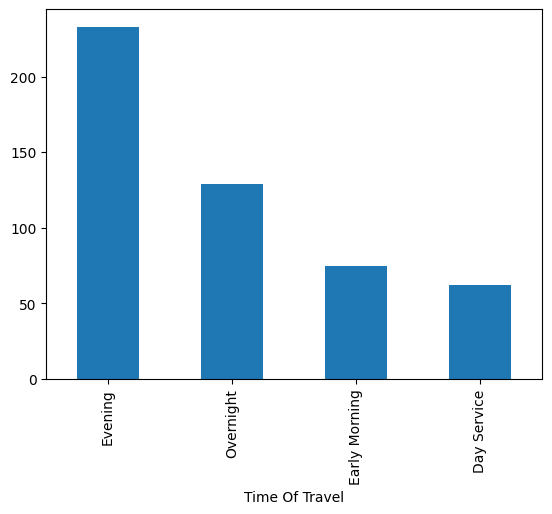

In [60]:
# Count number of bookings for each time-of-travel category
df['Time Of Travel'].value_counts().plot(kind='bar')       

### Meaningful Booking Behaviour Segments

This analysis segments customer booking behaviour based on
**Category** and **Time of Travel**.

By analysing revenue contribution across these dimensions,
we can identify meaningful booking patterns that reflect
customer preferences and revenue-driving segments.


In [61]:
# Create a pivot table to calculate total revenue
# grouped by Category and Time Of Travel
category_day_revenue = pd.pivot_table(df,
                        values='Total Ticket Amount',
                        index=['Category' , 'Time Of Travel'],
                        aggfunc='sum'
                    )

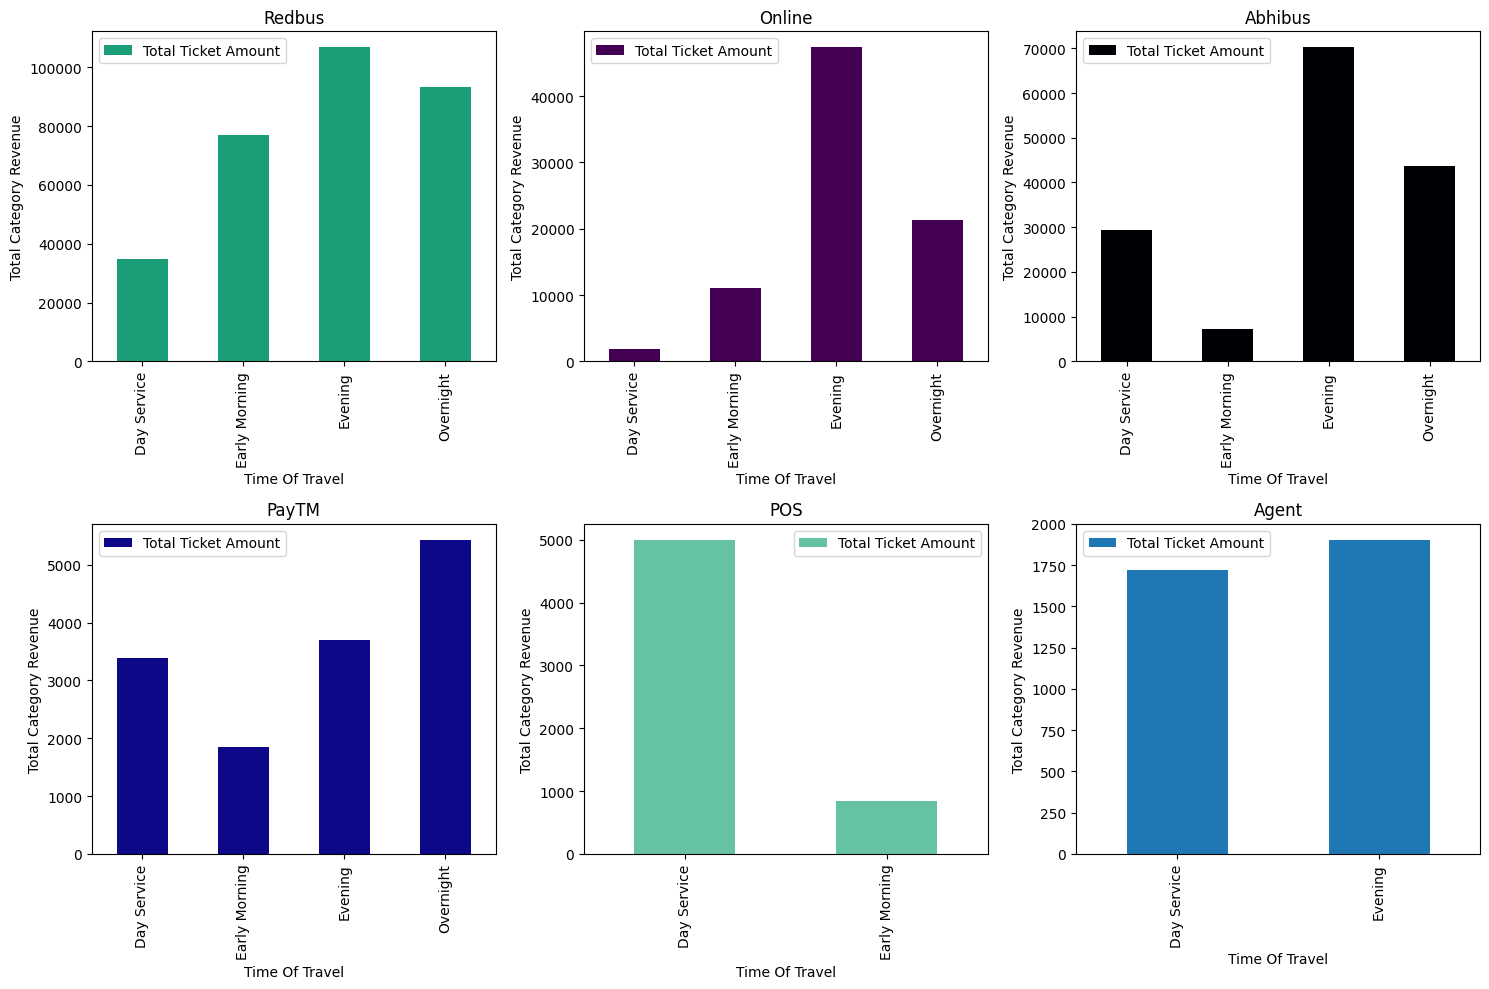

In [62]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))   # Create a grid of subplots (2 rows x 3 columns).Each subplot represents one ticket category
ax = ax.flatten()                                # Flatten axes for easier indexing
cmaps = [                                        # List of color maps for visual distinction
    "viridis", "plasma", "inferno", "magma", "cividis",
    "tab10", "tab20", "Set2", "Accent", "Dark2"
]

for i, category in enumerate(categories):      # Loop through each category and plot revenue by time of travel
    category_day_revenue.loc[category].plot(   # Plot time-of-travel-wise revenue for the category
        kind='bar',
        ax=ax[i],
        colormap=random.choice(cmaps),
        title=category
    )
    ax[i].set_xlabel("Time Of Travel")        # Set axis labels
    ax[i].set_ylabel("Total Category Revenue")


plt.tight_layout()                            # Adjust spacing to avoid overlapping plots
plt.show()                                    # Display all plots


In [63]:
gender_time_age_booking_counts = pd.pivot_table(df,
                        values='Ticket No',
                        index=['Gender' , 'Time Of Travel' , 'Age Group'],
                        aggfunc='count',
                        observed=False      # Explicitly setting behavior to avoid Future Warning
                    )

In [64]:
gender_time_age_booking_counts

Ticket No
Gender Time Of Travel Age Group           
F      Day Service    1-17               1
                      18-25             10
                      26-40              5
                      41-60              5
                      60+                0
       Early Morning  1-17               2
                      18-25              8
                      26-40             10
                      41-60             10
                      60+                3
       Evening        1-17               4
                      18-25             20
                      26-40             18
                      41-60             10
                      60+                1
       Overnight      1-17               1
                      18-25             11
                      26-40             12
                      41-60              7
                      60+                1
M      Day Service    1-17               4
                      18-25             17
                      26-40             13
                      41-60              7
                      60+                0
       Early Morning  1-17               5
                      18-25             12
                      26-40             16
                      41-60              8
                      60+                1
       Evening        1-17               5
                      18-25             50
                      26-40             94
                      41-60             27
                      60+                4
       Overnight      1-17               5
                      18-25             35
                      26-40             44
                      41-60             11
                      60+                2

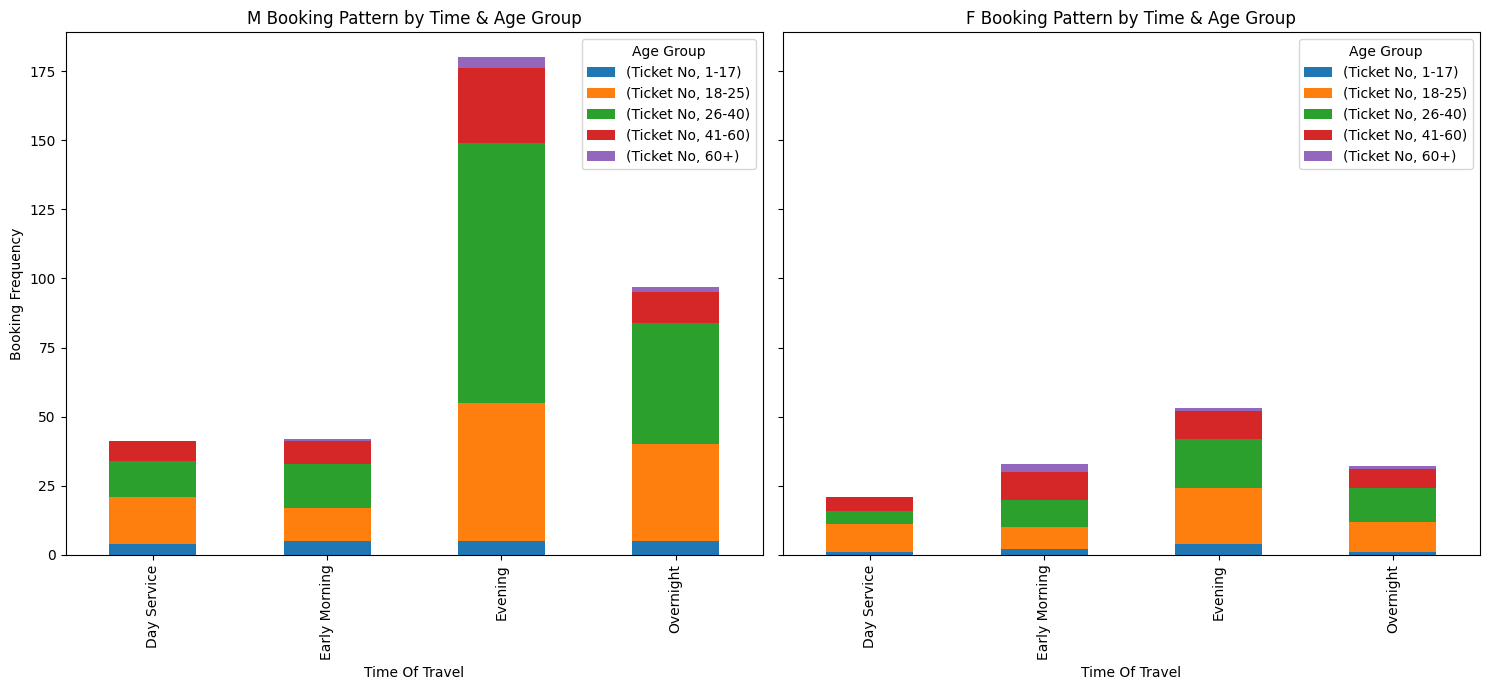

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
ax = ax.flatten()

for i, gender in enumerate(genders):
    data = (
        gender_time_age_booking_counts
        .loc[gender]              # Gender slice
        .unstack()                # Age Group becomes columns
    )

    data.plot(
        kind='bar',
        stacked=True,
        ax=ax[i],
        title=f"{gender} Booking Pattern by Time & Age Group"
    )

    ax[i].set_xlabel("Time Of Travel")
    ax[i].set_ylabel("Booking Frequency")
    ax[i].legend(title="Age Group")

plt.tight_layout()
plt.show()

### Route × Time of Travel Revenue Analysis

This analysis helps us understand:
- Which **routes** generate higher revenue
- At what **time of travel** (Morning / Evening / Overnight)
- And how revenue contribution varies across time slots for each route

This insight can be used for:
- Schedule optimization
- Dynamic pricing
- Fleet allocation (Sleeper vs Seater)


In [66]:
route_time_revenue = pd.pivot_table(           # Creating a pivot table to analyze revenue distribution across routes and time of travel
    df,
    values='Total Ticket Amount',              # Metric: Revenue
    index='Encode Route',                      # Rows: Routes
    columns='Time Of Travel',                  # Columns: Travel time slots
    aggfunc='sum'                              # Aggregation: Total revenue
)

In [67]:
route_time_revenue                             # Display the pivot table

Time Of Travel,Day Service,Early Morning,Evening,Overnight
Encode Route,,,,
BN-TP,11892.00,25244.0,26032.0,22132.3
BNG-CHN,3713.00,4113.0,28805.0,13857.0
BNG-ERD,NaN,960.0,3434.0,NaN
CHN-BNG,1992.00,5914.0,42593.0,4825.0
CHN-PND,907.00,5828.0,3387.0,1252.0
ELR-HYD,410.00,NaN,9119.0,NaN
ERD-BNG,NaN,NaN,1426.5,NaN
GNT-HYD,2374.00,NaN,19440.0,5638.2
GNT-VSKP,9781.00,NaN,35995.0,5722.0


### Revenue Heatmap: Route vs Time of Travel

This heatmap visualizes how total ticket revenue is distributed:
- Across different **routes**
- By **time of travel** (Early Morning, Day, Evening, Overnight)

Darkest shades represent **higher revenue contribution**, allowing quick
identification of:
- High-performing route–time combinations
- Underperforming travel slots
- Opportunities for schedule and pricing optimization

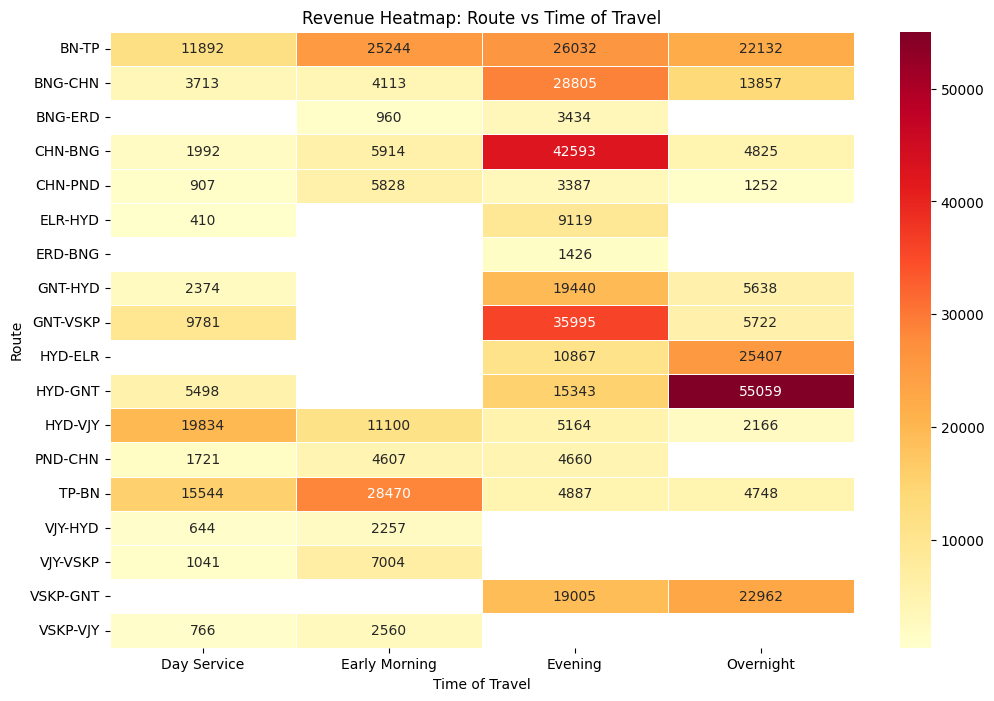

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))                     # Set figure size for better readability
sns.heatmap(                                    # Plot heatmap to visualize revenue concentration
    route_time_revenue,                         # Pivot table: Route × Time Of Travel
    cmap='YlOrRd',                              # Color gradient (low → high revenue)
    annot=True,                                 # Show revenue values on cells
    fmt='.0f',                                  # Format numbers (no decimals)
    linewidths=0.5                              # Separate cells for clarity
)

plt.title("Revenue Heatmap: Route vs Time of Travel") # Add descriptive titles and axis labels
plt.xlabel("Time of Travel")
plt.ylabel("Route")
plt.show()                                      # Render the plot

### Booking Volume by Route and Time of Travel

This pivot table calculates the **number of tickets booked** for each:
- Route
- Time of travel

It helps identify:
- Peak travel times for specific routes
- Demand-heavy routes
- Time slots with low bookings that may need optimization

In [69]:
# Create a pivot table to count bookings
# Rows: Encode Route (e.g., CHN-BNG)
# Columns: Time Of Travel (Early Morning, Day Service, Evening, Overnight)
# Values: Ticket No (count of bookings)route_time_bookings = pd.pivot_table(
route_time_bookings = pd.pivot_table(    
    df,
    values='Ticket No',                # Counting number of tickets
    index='Encode Route',              # Group by route
    columns='Time Of Travel',          # Split by travel time bucket
    aggfunc='count'                    # Count bookings
)

In [70]:
route_time_bookings                    # Display the pivot table

Time Of Travel,Day Service,Early Morning,Evening,Overnight
Encode Route,,,,
BN-TP,5.0,19.0,25.0,23.0
BNG-CHN,5.0,4.0,32.0,10.0
BNG-ERD,NaN,2.0,4.0,NaN
CHN-BNG,4.0,6.0,42.0,6.0
CHN-PND,1.0,6.0,5.0,2.0
ELR-HYD,1.0,NaN,17.0,NaN
ERD-BNG,NaN,NaN,4.0,NaN
GNT-HYD,2.0,NaN,25.0,9.0
GNT-VSKP,4.0,NaN,22.0,5.0


### Booking Volume Heatmap: Route vs Time of Travel

This heatmap visualizes the **number of ticket bookings** across different routes and time-of-travel categories. Darker colors indicate higher booking
volume, helping identify peak demand periods for each route.


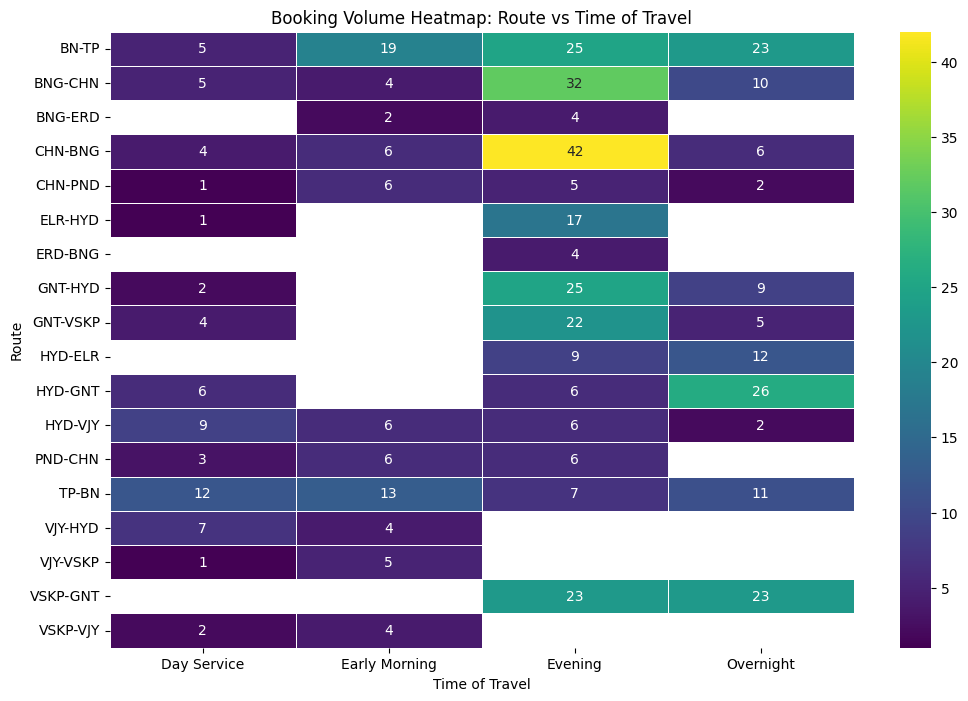

In [71]:
plt.figure(figsize=(12, 8))                     # Set the figure size for better readability
sns.heatmap(                                    # Plot a heatmap to visualize booking volume by route and time of travel
    route_time_bookings,                        # Pivot table containing booking counts
    cmap='viridis',                             # Color palette for visual intensity
    annot=True,                                 # Show booking counts inside cells
    linewidths=0.5                              # Add grid lines between cells
)

plt.title("Booking Volume Heatmap: Route vs Time of Travel")   # Add titles and axis labels for clarity
plt.xlabel("Time of Travel")
plt.ylabel("Route")
plt.show()                                      # Display the heatmap

In [72]:
df.to_csv('Final_bus.csv')